# Finetuning

Create custom dataset + finetune a bert model on it

## Structure

- `drive/MyDrive/Colab Notebooks/nlp2/NLPA-main.zip` is the zipped repo

---

In [9]:
!cp 'drive/MyDrive/Colab Notebooks/nlp2'/*.zip .
!unzip *.zip > /dev/null
!cd NLPA-main/datasets/FormAI && unzip *.zip > /dev/null

In [10]:
!cd NLPA-main/datasets/c-programs && python3 split.py > /dev/null

---

In [11]:
!pip install datasets 'transformers[torch]' evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 22.8 MB/s eta 0:00:00


In [77]:
from datasets import Dataset
import os
import glob


def to_hugging_faces(beginning_path : str, paths : list[str], status : int) -> Dataset :
    """
    @params
        paths: path to files to convert in dataset
        status: the status of the dataset generated or not
            warning in case of dataset that contains generated and non-generated
            modify the function

    @returns
        A Hugging Faces Dataset associating each file to its label
    """
    dict_dataset = {}
    for path in paths:
        f = open(beginning_path + path, "r")
        f_content = f.read()
        if ("text" in dict_dataset.keys()):
            dict_dataset["text"].append(f_content)
        else:
            dict_dataset["text"] = [f_content]
        if ("label" in dict_dataset.keys()):
            dict_dataset["label"].append(status)
        else:
            dict_dataset["label"] = [status]
    return dict_dataset


beginning_path = 'NLPA-main/datasets/FormAI/DATASET/'
paths = os.listdir(beginning_path)
first = to_hugging_faces(beginning_path, paths, 1)

beginning_path = 'NLPA-main/datasets/c-programs/'
paths = glob.glob(beginning_path + '*.c')
second = to_hugging_faces('', paths, 0)

dataset = Dataset.from_dict(first | second)

print('Data distribution:', len(first['text']), '/', len(second['text']))

Data distribution: 112000 / 208


In [78]:
print(dataset[0]['text'])
print('\nIs generated:', dataset[0]['label'])

#ifdef _OPENMP


Is generated: 0


---

In [79]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainerCallback
import matplotlib.pyplot as plt

In [80]:
# dataset = load_dataset("yelp_review_full")
# dataset["train"][100]

In [81]:
# TODO : Change tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [82]:
small_train_dataset = dataset.shuffle(seed=42).select(range(100)).map(tokenize_function, batched=True)
small_eval_dataset = dataset.shuffle(seed=42).select(range(100, 200)).map(tokenize_function, batched=True)

# small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000)).map(tokenize_function, batched=True)
# small_eval_dataset = dataset["test"].shuffle(seed=42).select(range(1000)).map(tokenize_function, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [83]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [103]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [104]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [105]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.000013,1.000000
2,No log,0.000003,1.000000
3,No log,0.000001,1.000000


TrainOutput(global_step=39, training_loss=1.3641408608796504e-05, metrics={'train_runtime': 38.4518, 'train_samples_per_second': 7.802, 'train_steps_per_second': 1.014, 'total_flos': 78933316608000.0, 'train_loss': 1.3641408608796504e-05, 'epoch': 3.0})

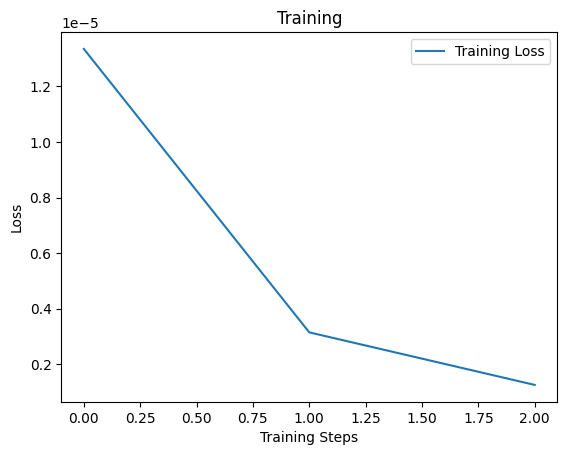

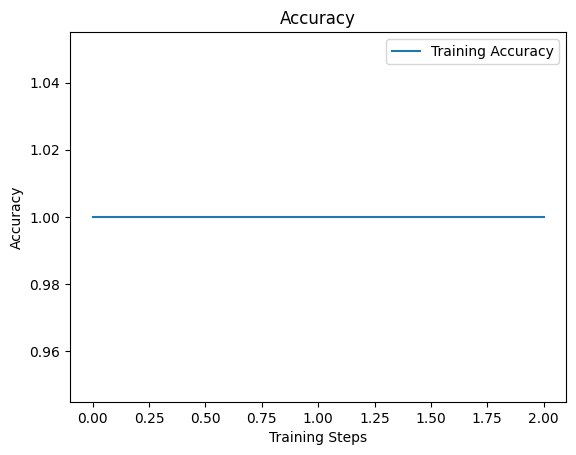

In [106]:
eval_losses = []
for log in trainer.state.log_history:
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])

eval_accuracies = []
for log in trainer.state.log_history:
    if 'eval_accuracy' in log:
        eval_accuracies.append(log['eval_accuracy'])

plt.title("Training")
plt.plot(eval_losses, label="Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.title("Accuracy")
plt.plot(eval_accuracies, label="Training Accuracy")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()